In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
resampled_dir = "../data/resampled/"
resampled_file_path = os.path.join(resampled_dir, "usdjpy-bar-test-2020-01-01-2024-12-31.pkl")
# resampled_file_path = os.path.join(resampled_dir, "usdjpy-bar-2020-01-01-2024-12-31.csv")

In [3]:
df = pd.read_pickle(resampled_file_path)
df.head()

,timestamp,open,high,low,close,volume
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024


# Sample smaller dataset

df = df[df['timestamp'].dt.year == 2024]
df.shape

# Dealing with NaN value

In [4]:
df.isna().sum()

timestamp         0
open         767480
high         767480
low          767480
close        767480
volume            0
dtype: int64

In [5]:
df = df.dropna()
df.isna().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

In [6]:
df.shape

(1860640, 6)

# Time grouping

By examining the data, we found that there are timeframes that only include Nan values. After clearing those NaN values, our time series data is no longer continuous, i.e. there're *time gaps*. Therefore, we need to group the data by checking their time continuity and assign *time_group* labels accordingly. This is a necessary process prior to the creation of sequences since *time gaps* can be huge and we don't want to create sequences or calculate indicators across them.

In [7]:
# Ensure df is a copy (not a view)
df = df.copy()

# Then assign safely
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'])
df.loc[:, 'time_delta'] = df['timestamp'].diff().dt.total_seconds()
df.loc[:, 'time_group'] = (df['time_delta'] != 60).cumsum().astype(int)
df = df.drop(columns='time_delta')

In [8]:
df.isna().sum()

timestamp     0
open          0
high          0
low           0
close         0
volume        0
time_group    0
dtype: int64

In [9]:
df[['timestamp', 'time_group']]

,timestamp,time_group
0,2020-01-01 22:00:00,1
1,2020-01-01 22:01:00,1
2,2020-01-01 22:02:00,1
3,2020-01-01 22:03:00,1
4,2020-01-01 22:04:00,1
...,...,...
2628115,2024-12-30 23:55:00,7375
2628116,2024-12-30 23:56:00,7375
2628117,2024-12-30 23:57:00,7375
2628118,2024-12-30 23:58:00,7375


In [10]:
df['time_group'].value_counts().sort_index()

time_group
1       255
2        50
3         7
4        58
5         5
       ... 
7371      1
7372      1
7373      1
7374     28
7375     35
Name: count, Length: 7375, dtype: int64

# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [11]:
GROUP_COl = 'time_group'

In [12]:
import numpy as np

def add_delta(df, price_col: str = 'close', group_col: str = 'time_group') -> pd.DataFrame:
    df = df.copy()

    def calc(group):
        group[f"{price_col}_delta"] = group[price_col] - group[price_col].shift(1)
        group[f"{price_col}_return"] = group[price_col] / group[price_col].shift(1) - 1
        return group

    df = df.groupby(group_col, group_keys=False).apply(calc)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df.reset_index(drop=True)


In [13]:
df = add_delta(df)

C:\Users\yoyo\AppData\Local\Temp\ipykernel_6076\3694927910.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_col, group_keys=False).apply(calc)


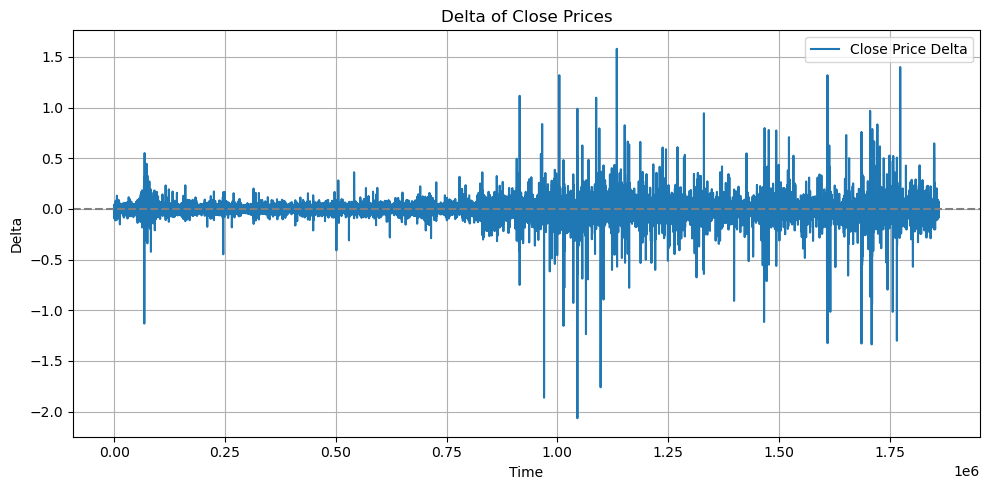

In [14]:
# Plot the delta
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_delta'], label='Close Price Delta')
plt.axhline(0, color='gray', linestyle='--')  # zero line
plt.title('Delta of Close Prices')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

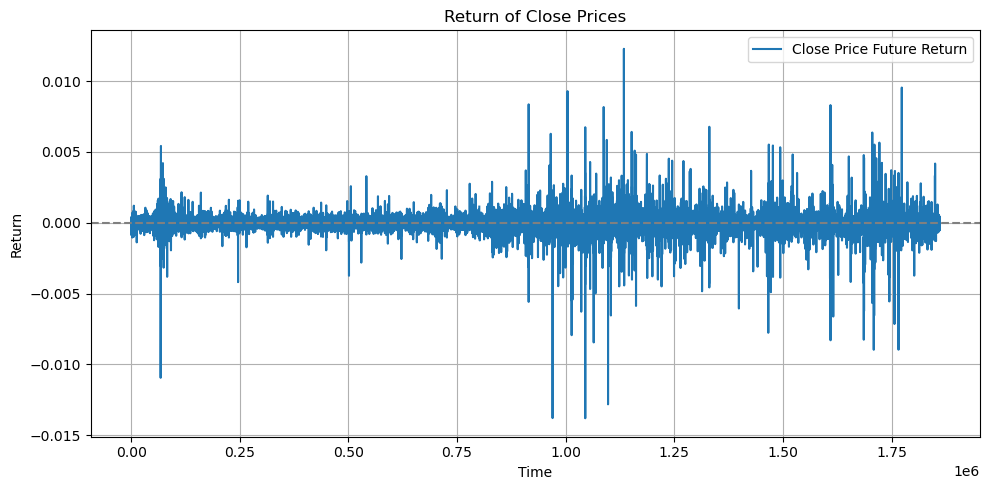

In [15]:
# Plot the return
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_return'], label='Close Price Future Return')
plt.axhline(0, color='gray', linestyle='--')  # zero line
plt.title('Return of Close Prices')
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
df[100:105]

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return
100,2020-01-01 23:40:00,108.6825,108.6845,108.6760,108.6770,49959.999800,1,-0.0050,-0.000046
101,2020-01-01 23:41:00,108.6780,108.6820,108.6775,108.6820,27549.999714,1,0.0050,0.000046
102,2020-01-01 23:42:00,108.6820,108.6820,108.6815,108.6815,16609.999895,1,-0.0005,-0.000005
103,2020-01-01 23:43:00,108.6815,108.6820,108.6810,108.6820,11369.999886,1,0.0005,0.000005
104,2020-01-01 23:44:00,108.6805,108.6820,108.6760,108.6760,188209.999323,1,-0.0060,-0.000055


In [17]:
df['time_group'].value_counts().sort_index()

time_group
1       255
2        50
3         7
4        58
5         5
       ... 
7371      1
7372      1
7373      1
7374     28
7375     35
Name: count, Length: 7375, dtype: int64

## Plot histgram

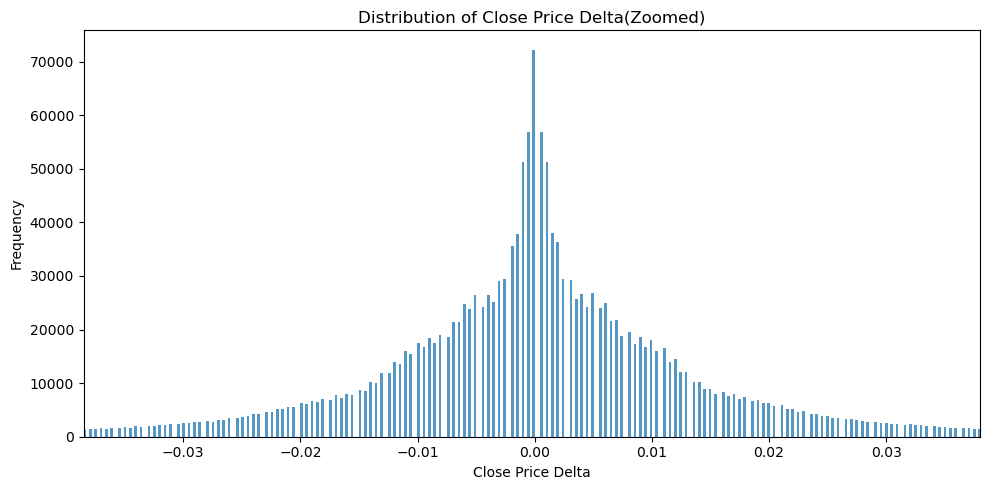

In [18]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

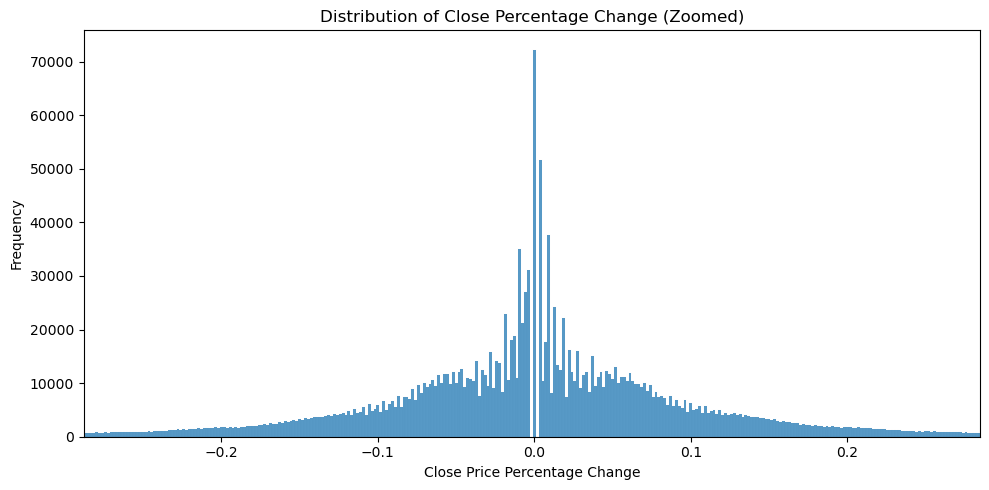

In [19]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()



In [20]:
df.isna().sum()

timestamp          0
open               0
high               0
low                0
close              0
volume             0
time_group         0
close_delta     7375
close_return    7375
dtype: int64

In [21]:
df = df.dropna()
df.isna().sum()

timestamp       0
open            0
high            0
low             0
close           0
volume          0
time_group      0
close_delta     0
close_return    0
dtype: int64

## Classification Labeling

## Add direction

In [22]:
def add_direction(df, delta_columns=['close'], threshold=0.005):
    """
    Add directional class labels based on deltas and a threshold.
    """
    df = df.copy()
    
    for col in delta_columns:
        df[f"{col}_direction"] =  df[f"{col}_return"].apply(lambda x: 'up' if x > threshold else ('down' if x < -threshold else 'flat'))
    return df

In [23]:
df = add_direction(df, threshold=3e-5)

In [24]:
df['close_direction'].value_counts()

close_direction
up      631189
down    621124
flat    600952
Name: count, dtype: int64

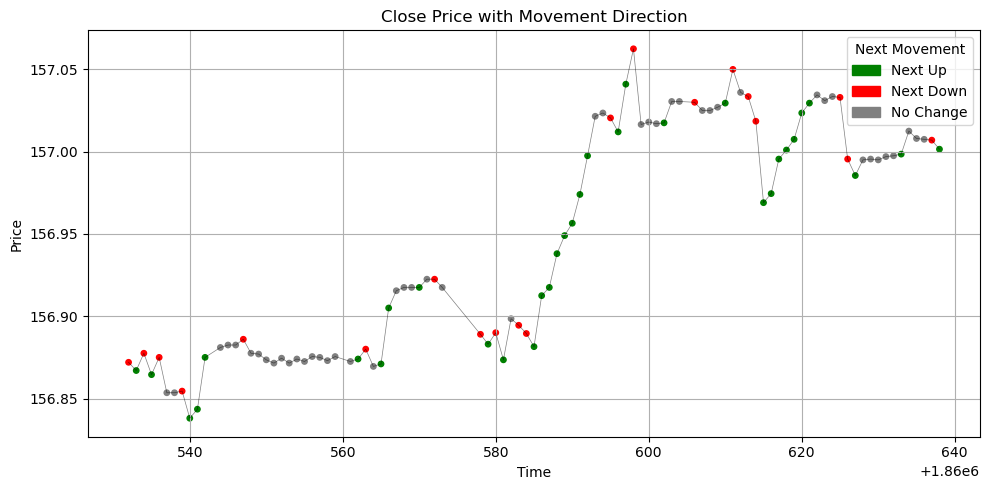

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Slice and shift for next movement direction
df_filtered = df[-101:].copy()
df_filtered['next_direction'] = df_filtered['close_direction'].shift(-1)
df_filtered = df_filtered[:-1]  # Drop the last row where next_direction is NaN

# Plot
plt.figure(figsize=(10, 5))

# Color map
colors = df_filtered['next_direction'].map({'up': 'green', 'down': 'red', 'flat': 'gray'})

# Plot scatter and line
plt.scatter(df_filtered.index, df_filtered['close'], c=colors, s=15)
plt.plot(df_filtered.index, df_filtered['close'], color='black', linewidth=0.5, alpha=0.5)

# Create manual legend
legend_patches = [
    mpatches.Patch(color='green', label='Next Up'),
    mpatches.Patch(color='red', label='Next Down'),
    mpatches.Patch(color='gray', label='No Change'),
]
plt.legend(handles=legend_patches, title='Next Movement')

# Final formatting
plt.title('Close Price with Movement Direction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,1,-0.0095,-0.000087,down
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,1,0.0040,0.000037,up
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,1,0.0020,0.000018,flat
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,1,0.0095,0.000087,up
5,2020-01-01 22:05:00,108.7700,108.7700,108.7690,108.7700,1059.999987,1,0.0050,0.000046,up


## Label encoding

## One Hot Encoding

In [30]:
# One-hot encode with get_dummies
one_hot = pd.get_dummies(df['close_direction'], prefix='prob').astype('float32')

df = df.join(one_hot)

df.head

<bound method NDFrame.head of                   timestamp      open      high       low     close  \
1       2020-01-01 22:01:00  108.7570  108.7590  108.7495  108.7495   
2       2020-01-01 22:02:00  108.7495  108.7535  108.7495  108.7535   
3       2020-01-01 22:03:00  108.7540  108.7555  108.7535  108.7555   
4       2020-01-01 22:04:00  108.7575  108.7650  108.7555  108.7650   
5       2020-01-01 22:05:00  108.7700  108.7700  108.7690  108.7700   
...                     ...       ...       ...       ...       ...   
1860635 2024-12-30 23:55:00  157.0100  157.0110  157.0075  157.0080   
1860636 2024-12-30 23:56:00  157.0075  157.0090  157.0075  157.0075   
1860637 2024-12-30 23:57:00  157.0035  157.0095  156.9900  157.0070   
1860638 2024-12-30 23:58:00  157.0080  157.0080  157.0000  157.0015   
1860639 2024-12-30 23:59:00  157.0010  157.0085  156.9980  157.0085   

                volume  time_group  close_delta  close_return close_direction  \
1         13300.000012           1  

In [31]:
from sklearn.preprocessing import LabelEncoder

def add_label(df, class_col='direction'):
    """
    Add directional class labels based on deltas and a threshold.
    """
    df = df.copy()
    
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[class_col])
    direction_counts = df["label"].value_counts()
    print(direction_counts)
    print(label_encoder.classes_)
    return df, label_encoder

In [32]:
df, encoder = add_label(df, class_col='close_direction')

label
2    631189
0    621124
1    600952
Name: count, dtype: int64
['down' 'flat' 'up']


In [33]:
import joblib

ENCODER_PATH = '../data/processed/label_encoder.pkl'

joblib.dump(encoder, ENCODER_PATH)

['../data/processed/label_encoder.pkl']

In [34]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction,prob_down,prob_flat,prob_up,label
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,1,-0.0095,-0.000087,down,1.0,0.0,0.0,0
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,1,0.0040,0.000037,up,0.0,0.0,1.0,2
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,1,0.0020,0.000018,flat,0.0,1.0,0.0,1
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,1,0.0095,0.000087,up,0.0,0.0,1.0,2
5,2020-01-01 22:05:00,108.7700,108.7700,108.7690,108.7700,1059.999987,1,0.0050,0.000046,up,0.0,0.0,1.0,2


# Timegroup Filtering

Before creating sequences, we have to make sure every **time group** have enough data to create at least **1** sequence.
Given the sequence length is X, horizon is H, each time group must have at least X + H timeframes. 

In [35]:
SEQ_LEN = 30
HORIZON = 1

min_len = SEQ_LEN + HORIZON
df = df.groupby("time_group").filter(lambda g: len(g) >= min_len)

In [36]:
df['time_group'].nunique()

2894

In [37]:
df['time_group'].value_counts()

time_group
164     7199
158     6659
4142    5763
6396    5703
6448    4370
        ... 
5901      31
1547      31
1595      31
5830      31
3800      31
Name: count, Length: 2894, dtype: int64

# Saving the file

In [38]:
PROCESSED_DIR = "../data/processed/"
PROCESSED_FILENAME = "usdjpy-bar-2020-01-01-2024-12-31_processed.pkl"
PROCESSED_FILE_PATH = os.path.join(PROCESSED_DIR, PROCESSED_FILENAME)

df.to_pickle(PROCESSED_FILE_PATH)